In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.sequence as seq
import pandas as pd
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\bar}{\,|\,}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Sequence Labelling 
assigns labels to each element in a sequence

## Example: PoS tagging

assign each token in a sentence its **Part-of-Speech tag**

|I | predict | I | won't | win | a | single | game |
|-|
|O | V | O | V | V | D | A | N |



## Example: Named Entity Recognition

label tokens as beginning (B), inside (I) our outside (O) a **named entity**

| Barack | Obama | was |  born | in | Hawaii |
|-|
| B-PER | I-PER | O |  O | O | B-LOC |


## Sequence Labelling as Structured Prediction

* Input Space $\Xs$: sequences of items to label
* Output Space $\Ys$: sequences of output labels labels
* Model: $s_{\params}(\x,\y)$
* Prediction: $\argmax_\y s_{\params}(\x,\y)$

## Conditional Models
model probability distributions over label sequences $\y$ conditioned on input sequences $\x$
$$
s_{\params}(\x,\y) = \prob_\params(\y|\x)
$$ 

* analog to conditional models of [text classification](doc_classify.ipynb) chapter

## Part-of-Speech Tagging as Sequence Labelling
Example data: tagging for tweets for the [Tweebank dataset](http://www.cs.cmu.edu/~ark/TweetNLP/#pos) 

In [2]:
def show_instance(x,y,begin=0,end=-1):
    return pd.DataFrame([x[begin:end],y[begin:end]]) 

In [3]:
train = seq.load_tweebank("../data/oct27.splits/oct27.train")
dev = seq.load_tweebank("../data/oct27.splits/oct27.dev")
test = seq.load_tweebank("../data/oct27.splits/oct27.test")
show_instance(*train[0],0,12)

,0,1,2,3,4,5,6,7,8,9,10,11
0,I,predict,I,won't,win,a,single,game,I,bet,on,.
1,O,V,O,V,V,D,A,N,O,V,P,","


Tags (such as "O", "V" and "^") are described in the [Tweebank annotation guideline](http://www.cs.cmu.edu/~ark/TweetNLP/annot_guidelines.pdf)

In [4]:
# count tags here?`xw
from collections import defaultdict
import pandas as pd
examples = {}
counts = defaultdict(int)
words = defaultdict(set)
for x,y in train:
    for i in range(0, len(x)):
        if y[i] not in examples:
            examples[y[i]] = [x[j] + "/" + y[j] if i == j else x[j] for j in range(max(i-2,0),min(i+2,len(x)-1))]
        counts[y[i]] += 1
        words[y[i]].add(x[i])
sorted_tags = sorted(counts.items(),key=lambda x:-x[1])
sorted_tags_with_examples = [(t,c,len(words[t])," ".join(examples[t])) for t,c in sorted_tags]

sorted_tags_table = pd.DataFrame(sorted_tags_with_examples, columns=['Tag','Count','Unique Words','Example'])

In [5]:
sorted_tags_table[:10]

,Tag,Count,Unique Words,Example
0,V,2219,873,I predict/V I
1,N,2003,1377,a single game/N I
2,",",1715,84,"bet on ./, Got"
3,P,1252,126,I bet on/P .
4,O,1063,97,I/O predict
5,^,890,741,. Got Cliff/^ Lee
6,D,869,68,won't win a/D single
7,A,755,449,win a single/A game
8,@,713,694,me RT @e_one/@ :
9,R,689,217,but I still/R hate


## Local Models / Classifiers
A **fully factorised** or **local** model:

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,i)
$$

* labels are independent of each other
* inference in this model is trivial
* Compare to ["Naive Translation Model"](word_mt.ipynb)

### Example

$$
\prob_\params(\text{"D A N"} \bar \text{"a single game"}) = \\\\ \prob_\params(\text{"D"}\bar \text{"a single game"},1) \prob_\params(\text{"A"} \bar \text{"a single game"},2) \ldots
$$

### Parametrisation

**Log-linear classifier** $p_\params(y\bar\x,i)$ to predict class for sentence $\x$ and position $i$

$$
  p_\params(y\bar\x,i) = \frac{1}{Z_\x} \exp \langle \repr(\x,i),\params_y \rangle
$$

What are good
### Features?

In [6]:
show_instance(*train[0],0,12)

,0,1,2,3,4,5,6,7,8,9,10,11
0,I,predict,I,won't,win,a,single,game,I,bet,on,.
1,O,V,O,V,V,D,A,N,O,V,P,","


Bias:
$$
\repr_0(\x,i) = 1
$$

Word at token to tag:
$$
\repr_w(\x,i) = \begin{cases}1 \text{ if }x_i=w \\\\ 0 \text{ else} \end{cases}
$$

In [7]:
def feat_1(x,i):
    return {
        'bias':1.0,  
        'word:' + x[i]: 1.0,
        'first_char:' + x[i][0:1]: 1.0
    }
local_1 = seq.LocalSequenceLabeler(feat_1, train, class_weight='balanced')

We can assess the accuracy of this model on the development set.

In [8]:
seq.accuracy(dev, local_1.predict(dev))

0.7903794318888658

### How to Improve?

Look at **confusion matrix**

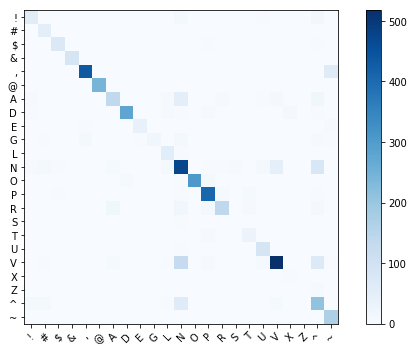

In [9]:
seq.plot_confusion_matrix(dev, local_1.predict(dev))

Shows:

* strong diagonal (good predictions)
* `N` receives a lot of wrong counts 
* `@` complete failure

Let us start with @ ... 

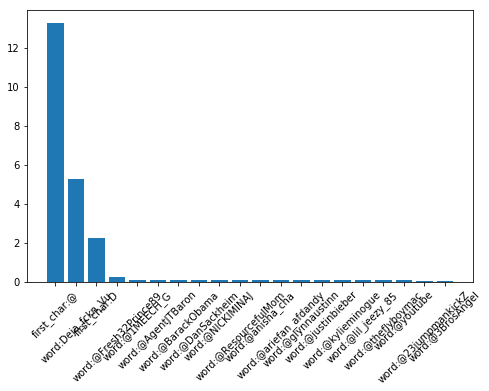

In [10]:
local_1.plot_lr_weights('@')

Features for **specific users** such as "word=@justinbieber" do not generalise well

How to address this? 

In [11]:
def feat_2(x,i):
    return {
        **feat_1(x,i),
        'first_at:' + x[i][0:1]: 1.0
    }
local_2 = seq.LocalSequenceLabeler(feat_2, train)
seq.accuracy(dev, local_2.predict(dev))

0.79411154882853

To confirm that these results actually from improved '@' prediction, let us look at the confusion matrix again

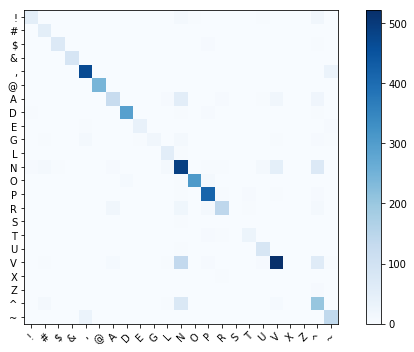

In [12]:
seq.plot_confusion_matrix(dev, local_2.predict(dev))

Solved! 

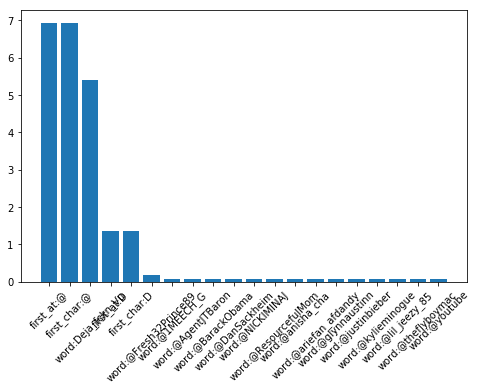

In [13]:
local_2.plot_lr_weights('@')

Other errors?

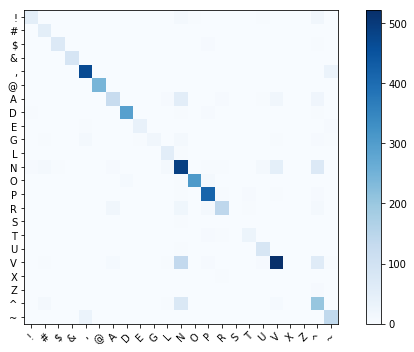

In [14]:
seq.plot_confusion_matrix(dev, local_2.predict(dev))

Look for errors with high frequency:

* distinguishing **proper nouns** (label '^') 
    * such as "McDonalds" or "Thursday" 
* from **common nouns** (label 'N') 
    * such as "wife" or "rain". 

### Micro View
How do these errors look like?

In [15]:
util.Carousel(local_2.errors(dev[10:20], 
                             filter_guess=lambda y: y=='N',
                             filter_gold=lambda y: y=='^'))

Proper nouns tend to be capitalised!

In [16]:
def feat_3(x,i):
    return {
        **feat_2(x,i),
        'is_lower:' + str(x[i].islower()): 1.0
    }
local_3 = seq.LocalSequenceLabeler(feat_3, train, C=10)
seq.accuracy(dev, local_3.predict(dev))

0.7939042089985486

This improvement indeed comes from being able to identify proper nouns when they are capitalised:

In [17]:
util.Carousel(local_3.errors(dev[10:20], 
                             filter_guess=lambda y: y=='N',
                             filter_gold=lambda y: y=='^'))
# seq.find_contexts(train, lambda w: w == 'Senate')

Find more problems:

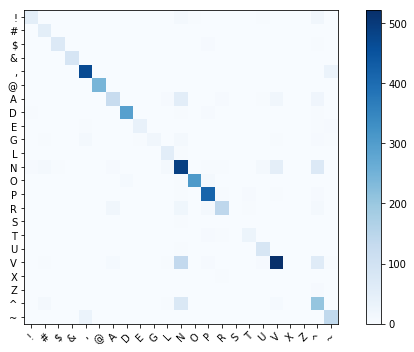

In [18]:
seq.plot_confusion_matrix(dev, local_3.predict(dev))

High frequency error: 

* misclassifying verbs ('V') as common nouns ('N')

Inspect examples... 

In [19]:
util.Carousel(local_3.errors(dev[:20], 
                             filter_guess=lambda y: y=='N',
                             filter_gold=lambda y: y=='V'))

* "laughing", "blowing" or "passed" are misclassified as common nouns 
* For $f_{\text{word},w}$ feature template weights are $0$ 

Suggests that word has not appeared (or not appeared as a verb) in the training set! 

However, we can tell that these words may be verbs:

* check suffixes such as "ing" or "ed". 

Incorporate as features!

In [20]:
def feat_4(x,i):
    return {
        **feat_3(x,i),
        'last_3' + "".join(x[i][-3:]): 1.0,
        'last_2' + "".join(x[i][-2:]): 1.0,
    }
local_4 = seq.LocalSequenceLabeler(feat_4, train)
seq.accuracy(dev, local_4.predict(dev))

0.819199668256272

In [21]:
util.Carousel(local_4.errors(dev[:20], 
                             filter_guess=lambda y: y=='N',
                             filter_gold=lambda y: y=='V' ))

## Markov Models
We have **dependencies** between consecutive labels

### Example

after non-possessive pronoun ("O") such as "I" a verb ("V") is more likely than a noun ("N")

*local* model cannot capture this

## Maximum Entropy Markov Model
$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,y_{i-1},i)
$$

a product of local logistic regression (aka Maximum Entropy) classifiers $\prob_\params(y_i|\x,y_{i-1},i)$

* but classifiers can use the previous label as observed feature 
* makes a **first-order Markov assumption**



### Example

$$
\prob_\params(\text{"D A N"} \bar \text{"a single game"}) = \\\\ \prob_\params(\text{"D"}\bar \text{"a single game"},\text{"PAD"},1) \\\\ \prob_\params(\text{"A"} \bar \text{"a single game"},\text{"D"},2) \ldots
$$

Log-linear version with access to previous label: 

$$
  p_\params(y_i|\x,y_{i-1},i) = \frac{1}{Z_{\x,y_{i-1},i}} \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle
$$

where $Z_{\x,y_{i-1},i}=\sum_y \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle $ is a *local* per-token normalisation factor

### Training MEMMs
Optimising the conditional likelihood 

$$
\sum_{(\x,\y) \in \train} \log \prob_\params(\y|\x)
$$

Decomposes nicely: 
$$
\sum_{(\x,\y) \in \train} \sum_{i=1}^{|\x|} \log \prob_\params(y_i|\x,y_{i-1},i)   
$$

Easy to train
* Equivalent to a **logistic regression objective** for a classifier that assigns labels based on previous gold labels

Let's specify a MEMM using 
### Feature Functions

In [22]:
def memm_feat_1(x,i,hist):
    return {
        **feat_4(x,i),
        'prev_y': hist[0],
    }

memm_1 = seq.MEMMSequenceLabeler(memm_feat_1, train, order=1, C=10)

## Prediction in MEMMs
To predict the best label sequence find a $\y^*$ with maximal conditional probability

$$
\y^* =\argmax_\y \prob_\params(\y|\x).
$$

### Greedy Prediction
We cannot simply choose each label in isolation because **decisions depend on each other**

Simple alternative:
* Choose highest scoring label for token 1
* Choose highest scoring label for token 2, conditioned on best label from 1
* etc.

In [23]:
memm_1.predict_next(["the","man"],0,[])

'D'

In [24]:
memm_1.predict_next(["the","man"],1,['D'])

'N'

In [25]:
def memm_greedy_predict(memm: seq.MEMMSequenceLabeler, data, use_gold_history=False):
    result = []
    for x, y in data:
        y_guess = []
        for i in range(0, len(x)):
            prediction = memm.predict_next(x, i, y_guess if not use_gold_history else y)
            y_guess.append(prediction)
        result.append(y_guess)
    return result

In [26]:
seq.accuracy(dev,memm_greedy_predict(memm_1, dev))

0.8374455732946299

Some Noun vs Verb errors fixed:

In [27]:
util.Carousel(seq.errors(dev[:20], memm_greedy_predict(memm_1, dev[:20]), 
                         'V', 'N',model=memm_1))

For the case of verbs ('V') we observe a high weight for $f_{\text{prev_y},\text{O}}$

* indicating that pronouns are often followed by verbs, as we expected earlier  

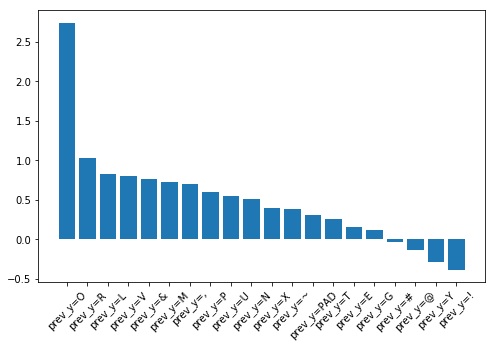

In [28]:
memm_1.plot_lr_weights('V',feat_filter=lambda s: s.startswith("prev_"))

Greedy decoding may lead to
## Search Errors

when returned $\y^*$ is not highest scoring **global** solution

In [29]:
memm_1.predict_label_scores(["What","better","way"],0,[])[:3]

[('O', -0.18323268433010617),
 ('D', -2.1261763205119384),
 ('^', -4.2788694850074531)]

In [30]:
memm_1.predict_label_scores(["What","better","way"],1,['O'])[:3]

[('R', -0.57067589094444393),
 ('A', -1.0649403220853073),
 ('V', -2.5922357668696887)]

In [31]:
memm_1.predict_label_scores(["What","better","way"],2,['O','R'])[:3]

[('N', -0.82070510493360094),
 ('V', -1.0810669092678737),
 ('R', -1.8783272585297461)]

Use
### Beam Search
and remember a beam of previous solutions

In [32]:
x = ["What","better","way"]
init_beam = []
for y, score in memm_1.predict_label_scores(x,1,['O']):
    init_beam.append((('O',y),score))
beam_size = 3
beam = init_beam[:beam_size]
beam

[(('O', 'R'), -0.57067589094444393),
 (('O', 'A'), -1.0649403220853073),
 (('O', 'V'), -2.5922357668696887)]

In [33]:
new_beam = []
for prev_y, prev_s in beam:
    for y,s in memm_1.predict_label_scores(x,2,prev_y):
        new_beam.append((prev_y + (y,), prev_s + s))
new_beam[0:10]

[(('O', 'R', 'N'), -1.3913809958780448),
 (('O', 'R', 'V'), -1.6517428002123178),
 (('O', 'R', 'R'), -2.4490031494741902),
 (('O', 'R', 'A'), -4.2603096087337127),
 (('O', 'R', 'O'), -4.9708065712009093),
 (('O', 'R', 'P'), -5.192632529257275),
 (('O', 'R', 'L'), -5.4926029496724187),
 (('O', 'R', '!'), -5.6593723563599907),
 (('O', 'R', 'G'), -6.8571014299488775),
 (('O', 'R', '^'), -6.9791557091426295)]

In [34]:
def memm_beam_search(memm, x, width=2):
    beam = [([],0.)]
    history = [beam]
    for i in range(0, len(x)):
        # use priority queue 
        candidates = []
        for (prev,score) in beam:
            scores = memm.predict_scores(x, i, prev)
            for label_index,label_score in enumerate(scores):
                candidates.append((prev + [memm.labels()[label_index]], score + label_score))
        beam = sorted(candidates, key=lambda x: -x[1])[:width]
        history.append(beam)
    return beam, history
            
def batch_predict(data, beam_predictor):
    return [beam_predictor(x)[0][0][0] for x,y in data]


Full Example:

In [35]:
example = 56
beam, history = memm_beam_search(memm_1, dev[example][0],3)
seq.render_beam_history(history, dev[example], end=17)

Does it this help?

In [36]:
seq.accuracy(dev, batch_predict(dev, lambda x: memm_beam_search(memm_1, x, 2)))

0.8397263114244247

Beam search is wasteful for first-order models, instead use 
## Viterbi Algorithm

Consider a beam of size 2:

In [37]:
example = 56
beam, history = memm_beam_search(memm_1, dev[example][0],2)
seq.render_beam_history(history, dev[example], end=17)

Histories differ in early positions, but does the all the past matter?

In [38]:
memm_1.predict_label_scores(["What","better","way"],2,['O','R'])[:3]

[('N', -0.82070510493360094),
 ('V', -1.0810669092678737),
 ('R', -1.8783272585297461)]

Past only matters until the **previous token**

**Viterbi Algorithm** = Remember only the best history per label 

In [39]:
from collections import defaultdict
import math
def memm_viterbi_search(memm, x, width=2):
    labels = memm.labels()
    # initialise
    alpha = [{}]
    beta = [{}]
    for label_index, label_score in enumerate(memm.predict_scores_hist(x, 0, ["PAD"])):
        label = labels[label_index]
        alpha[0][label] = label_score
        beta[0][label] = "PAD"
    
    # prune
    seq.prune_alpha_beta(alpha[0], beta[0], width)
    
    # recursion 
    for i in range(1, len(x)):
        alpha.append(defaultdict(lambda: -math.inf))
        beta.append({})
        for p in alpha[i-1].keys():
            for label_index, label_score in enumerate(memm.predict_scores_hist(x, i, [p])):
                label = labels[label_index]
                new_score =  alpha[i-1][p] + label_score
                if new_score > alpha[i][label]:
                    alpha[i][label] = new_score
                    beta[i][label] = p
        # prune
        seq.prune_alpha_beta(alpha[i], beta[i], width)
    
    # convert to beam history to be used in the same way beam search was used.  
    history = seq.convert_alpha_beta_to_history(x, alpha, beta)
    return history[-1], history

In action:

In [40]:
beam, history = memm_viterbi_search(memm_1, dev[example][0],2)
seq.render_beam_history(history, dev[example], 17)

Now, does this help?

In [41]:
seq.accuracy(dev, batch_predict(dev, lambda x: memm_viterbi_search(memm_1, x, 2)))

0.841177690234294

Check Models on Test Set:

In [42]:
pd.DataFrame([
        ["word", seq.accuracy(test, local_1.predict(test))],
        ["+ first @", seq.accuracy(test, local_2.predict(test))],
        ["+ cap", seq.accuracy(test, local_3.predict(test))],
        ["+ suffix", seq.accuracy(test, local_4.predict(test))],
        ["MEMM", seq.accuracy(test, memm_1.predict(test))],
    ])

,0,1
0,word,0.786074
1,+ first @,0.794603
2,+ cap,0.794603
3,+ suffix,0.821588
4,MEMM,0.839346


## Summary
* Many problems can be cast as sequence labeling
* Solution 1: sequence of classifiers
    * rely on good feature engineering
* Solution 2: MEMM to model label dependencies
    * require non-trivial search algorithms
    * but greedy and beam search often works well
* Other Options:
    * CRFs (in notes)
    * RNNs (discussed later)

## Background Material
* [Tackling the Poor Assumptions of Naive Bayes Text Classifiers](https://people.csail.mit.edu/jrennie/papers/icml03-nb.pdf), Rennie et al, ICML 2003 
* [MEMM](http://www.ai.mit.edu/courses/6.891-nlp/READINGS/maxent.pdf)